# Телеком — задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников. Во всех таблицах присутсвует поле  
**customerID: уникальный идентификатор клиента**

**- `contract.csv` — информация о договоре:**

-     BeginDate: дата начала пользования услугами;
-     EndDate: дата окончания пользования услугами;
-     Type: тип оплаты (ежемесячный, годовой и т.п.);
-     Paperlessbilling: электронный платежный документ;
-     PaymentMethod: способ оплаты;
-     MonthlyCharges: ежемесячная траты на услуги;
-     TotalCharges: общие затраты на услуги.

**- `personal.csv` — персональные данные клиента:**
-     Gender: пол клиента;  
-     SeniorCitizen: статус пенсионера;  
-     Partner: наличие супруга(и);  
-     Dependents: наличие иждивенцев.

**- `internet.csv` — информация об интернет-услугах:**
-     InternetService: тип подключения: через линию-DSL или оптокабель-Fiber optic;  
-     OnlineSecurity: наличие услуги блокировки небезопасных сайтов;  
-     OnlineBackup: наличие облачного хранилища для резервирования данных;  
-     DeviceProtection: наличие услуги антивируса;
-     TechSupport: наличие выделенной линии технической поддержки;
-     StreamingTV: наличие услуги стримингового телевидиния;
-     StreamingMovies: наличие услуги каталога фильмов.

**- `phone.csv` — информация об услугах телефонии:**
-     MultipleLines: налачие возможности нескольких линий во время звонка.


**Информация о договорах актуальна на 1 февраля 2020.**


### Данные

[final_provider.zip](https://s3-us-west-2.amazonaws.com/secure.notion-static.com/ac39c23b-718e-4cd6-bdaa-85b3a127a457/final_provider.zip)

Данные также находятся в тренажёре, в папке `/datasets/final_provider/`.

In [1]:
#all imports and CONSTANTS
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

RS = 120922
pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
!pip install phik
import phik
from phik import resources, report
from sklearn.preprocessing import  OneHotEncoder



     |████████████████████████████████| 709 kB 2.5 MB/s eta 0:00:01


Загружаем данные

In [2]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

dfs = [contract, personal, internet, phone]

Изучим общую информацию о датафреймов

In [3]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

def get_info(df):
    display(get_df_name(df))
    display(df.sample(3))
    display(df.info())
    display(df.describe())
    print('====='*10)

In [4]:
for df in dfs:
    get_info(df)

'contract'

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
5066,7191-ADRGF,2016-06-01,No,Two year,No,Bank transfer (automatic),54.30,2390.45
6623,9248-OJYKK,2019-09-01,2019-10-01 00:00:00,Month-to-month,Yes,Electronic check,76.45,76.45
2831,2454-RPBRZ,2018-10-01,2019-10-01 00:00:00,Month-to-month,Yes,Electronic check,98.10,1060.2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


'personal'

,customerID,gender,SeniorCitizen,Partner,Dependents
5915,9500-WBGRP,Male,0,No,No
127,6734-PSBAW,Male,0,Yes,No
3521,2550-AEVRU,Female,0,Yes,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


'internet'

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1870,6993-YGFJV,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
3179,0757-WCUUZ,DSL,No,No,Yes,No,No,Yes
2034,3096-YXENJ,Fiber optic,No,Yes,Yes,Yes,Yes,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,9309-BZGNT,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


'phone'

,customerID,MultipleLines
4999,3173-NVMPX,Yes
1647,6016-LVTJQ,No
4151,7639-SUPCW,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,3916-NRPAP,No
freq,1,3390


Суть задачи: данные размещенны в 4 датафреймах, связующим во всех четырех таблицах является поле customerID. Цель - спроектировать модель бинарной классификации: клиент скоро уйдет/клиент не собирается уходить. 
Так как имеем значительное число категориальных данных, будем ориентироваться на модели  RandomForest, CatBoost, LightGBM.  

<b>План работы:</b>
1. Исправляем название columns в snake_case, 
    посмотрим на duplicates, 
    nan, если есть возможность заполнить пропуски, заполним, 
    обработаем корректность типов данных (числа, даты)
2. Посмотрим на выборосы, в случае если детектируем явные выбросы - удалим.
3. Возможно заменим строковые данные на бинарные. 
4. Подумать над созданием дополнительных признаков, а также сгенерировать целевой признак. Выделить категориальные признаки    
5. Разбить данные на выборки
6. Используя GridSearchCV и/или RandomizedSearchCV попробуем подобрать оптимальные гиперпараметры моделей
7. Выявляем оптимальную модель, анализируем результаты и делаем выводы.    

In [5]:
contract.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

Переименуем столбцы датафреймов в snake_case тип:

In [6]:
def splitAtUpperCase(text): # вспомогательная функция для разделения текста по upper case
    result = ""
    for char in text:
        if char.isupper():
            result += "_" + char.lower()
        else:
            result += char
    return result.strip('_')

In [7]:
def rename_columns(df):
    df.rename(columns=dict(zip(df.columns, [splitAtUpperCase(i) for i in df.columns])), inplace=True)
    df.rename(columns={'customer_i_d':'customer_id'}, inplace=True) # устраняем недоделки нашей функции splitAtUpperCase
    
  

In [8]:
internet.rename(columns={'streaming_t_v':'streaming_tv'}, inplace=True) 

for df in dfs:
    rename_columns(df)
    print(df.columns)    

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')
Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')
Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_t_v',
       'streaming_movies'],
      dtype='object')
Index(['customer_id', 'multiple_lines'], dtype='object')


Добавим целевую переменную и заменим дату незавершения договора на дату выгрузки данных:

In [9]:
contract['gone'] = (contract['end_date'] != 'No').astype(int)

In [10]:
contract['end_date'].replace({'No': '2020-02-01'}, inplace=True)

Преобразуем строковые бинарные данные в цифровые.

In [11]:
for df in dfs:
    df.replace({'Yes':1, 'No':0}, inplace=True)

Посмотрим на типы данных в колонках датафреймов

In [12]:
for df in dfs:
    get_info(df)

'contract'

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gone
6836,5868-YWPDW,2019-05-01,2019-11-01 00:00:00,Month-to-month,1,Electronic check,84.2,519.15,1
1731,8375-DKEBR,2019-12-01,2020-01-01 00:00:00,Month-to-month,1,Electronic check,69.6,69.6,1
4184,0495-ZBNGW,2019-05-01,2019-10-01 00:00:00,Month-to-month,1,Bank transfer (automatic),79.9,343.95,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   int64  
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gone               7043 non-null   int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 495.3+ KB


None

,paperless_billing,monthly_charges,gone
count,7043.000000,7043.000000,7043.000000
mean,0.592219,64.761692,0.265370
std,0.491457,30.090047,0.441561
min,0.000000,18.250000,0.000000
25%,0.000000,35.500000,0.000000
50%,1.000000,70.350000,0.000000
75%,1.000000,89.850000,1.000000
max,1.000000,118.750000,1.000000


'personal'

,customer_id,gender,senior_citizen,partner,dependents
3856,6710-HSJRD,Male,0,1,0
5717,8169-SAEJD,Male,1,1,0
3756,9136-ALYBR,Male,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   int64 
 4   dependents      7043 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 275.2+ KB


None

,senior_citizen,partner,dependents
count,7043.000000,7043.000000,7043.000000
mean,0.162147,0.483033,0.299588
std,0.368612,0.499748,0.458110
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000


'internet'

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies
1776,6204-IEUXJ,Fiber optic,0,0,1,1,0,0
2804,5913-INRQV,Fiber optic,1,0,0,1,1,0
5049,4726-DLWQN,DSL,1,1,0,0,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   int64 
 3   online_backup      5517 non-null   int64 
 4   device_protection  5517 non-null   int64 
 5   tech_support       5517 non-null   int64 
 6   streaming_t_v      5517 non-null   int64 
 7   streaming_movies   5517 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 344.9+ KB


None

,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies
count,5517.000000,5517.000000,5517.000000,5517.000000,5517.000000,5517.000000
mean,0.365960,0.440276,0.439007,0.370491,0.490665,0.495197
std,0.481742,0.496465,0.496311,0.482980,0.499958,0.500022
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


'phone'

,customer_id,multiple_lines
2707,9348-ROUAI,1
157,5918-VUKWP,0
1170,8800-ZKRFW,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 99.5+ KB


None

,multiple_lines
count,6361.000000
mean,0.467065
std,0.498953
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [13]:
contract['begin_date'] = pd.to_datetime(contract['begin_date'], format='%Y-%m-%d')
contract['end_date'] = pd.to_datetime(contract['end_date'], format='%Y-%m-%d')
contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gone
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,1889.5,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,1


In [14]:
contract.query("total_charges==' '") 

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gone
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,1,Bank transfer (automatic),52.55,,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,0,Mailed check,20.25,,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,0,Mailed check,80.85,,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,0,Mailed check,25.75,,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,0,Credit card (automatic),56.05,,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,0,Mailed check,19.85,,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,0,Mailed check,25.35,,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,0,Mailed check,20.00,,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,1,Mailed check,19.70,,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,0,Mailed check,73.35,,0


Эти данные можно считать "шумом", они только что зарегистрировались(на момент выгрузки данных), их лучше удалить

In [15]:
contract['total_charges'].replace({' ': np.nan}, inplace=True)
contract.dropna(inplace=True)
contract['total_charges'] = contract['total_charges'].astype('float')

Выделем дополнительный признак - как долго клиент остается с компанией.

In [16]:
contract['cooperation_time'] = contract['end_date'].dt.to_period('D').view(dtype='int64')- contract['begin_date'].dt.to_period('D').view(dtype='int64')

Сравним распределения величин ежемесячных платежей (MonthlyCharges) всех клиентов и тех, кто ушёл. Для каждой группы посчитаем статистики: средние, минимальные и максимальные значения, медиану и величины 25%- и 75%-квартилей. Построим гистограммы распределения.

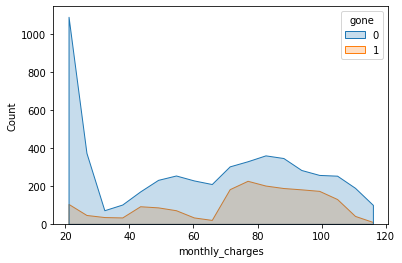

In [17]:
sns.histplot(data=contract, x="monthly_charges", hue="gone", element="poly")
plt.show()

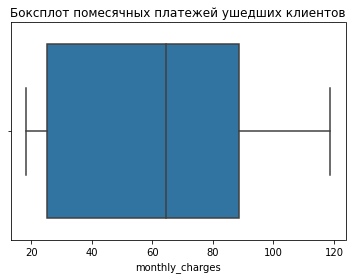

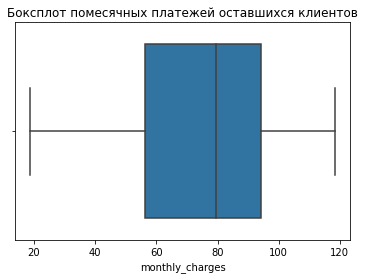

In [18]:
monthly_charges_0 = sns.boxplot(data=contract.query("gone==0"), x="monthly_charges")
monthly_charges_0.set_title('Боксплот помесячных платежей ушедших клиентов')
plt.show()
monthly_charges_1 = sns.boxplot(data=contract.query("gone==1"), x="monthly_charges")
monthly_charges_1.set_title('Боксплот помесячных платежей оставшихся клиентов')
plt.show()

In [19]:
contract.query("gone==0").describe()

,paperless_billing,monthly_charges,total_charges,gone,cooperation_time
count,5163.000000,5163.000000,5163.000000,5163.0,5163.000000
mean,0.536122,61.307408,2555.344141,0.0,1146.885532
std,0.498742,31.094557,2329.456984,0.0,732.773458
min,0.000000,18.250000,18.800000,0.0,31.000000
25%,0.000000,25.100000,577.825000,0.0,457.000000
50%,1.000000,64.450000,1683.600000,0.0,1157.000000
75%,1.000000,88.475000,4264.125000,0.0,1857.000000
max,1.000000,118.750000,8672.450000,0.0,2191.000000


In [20]:
contract.query("gone==1").describe()

,paperless_billing,monthly_charges,total_charges,gone,cooperation_time
count,1869.000000,1869.000000,1869.000000,1869.0,1869.000000
mean,0.749064,74.441332,1531.796094,1.0,547.352060
std,0.433668,24.666053,1890.822994,0.0,594.389607
min,0.000000,18.850000,18.850000,1.0,30.000000
25%,0.000000,56.150000,134.500000,1.0,61.000000
50%,1.000000,79.650000,703.550000,1.0,304.000000
75%,1.000000,94.200000,2331.300000,1.0,883.000000
max,1.000000,118.350000,8684.800000,1.0,2191.000000


Наибольшее количество ушедших клиентов ежемесячно вносили плату в районе 75-105 рублей (предполагаем, что рублей).

In [21]:
#########

Создаем общий датафрейм

In [22]:
all_data = contract.merge(personal, on='customer_id', how='left')
all_data = all_data.merge(internet, on='customer_id', how='left')
all_data = all_data.merge(phone, on='customer_id', how='left')


In [23]:
all_data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gone,cooperation_time,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,29.85,0,31,Female,0,1,0,DSL,0.0,1.0,0.0,0.0,0.0,0.0,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,1889.50,0,1036,Male,0,0,0,DSL,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,1,61,Male,0,0,0,DSL,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,1840.75,0,1371,Male,0,0,0,DSL,1.0,0.0,1.0,1.0,0.0,0.0,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,1,61,Female,0,0,0,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,0.0


После объеденения датайфремов можно обраружить пропуски в данных

In [24]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   datetime64[ns]
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   int64         
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gone               7032 non-null   int64         
 9   cooperation_time   7032 non-null   int64         
 10  gender             7032 non-null   object        
 11  senior_citizen     7032 non-null   int64         
 12  partner            7032 non-null   int64         
 13  dependents         7032 non-null   int64         
 14  internet

In [25]:
all_data.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gone',
       'cooperation_time', 'gender', 'senior_citizen', 'partner', 'dependents',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_t_v',
       'streaming_movies', 'multiple_lines'],
      dtype='object')

Пропуски в колонках 'internet_service', 'online_security', 'online_backup',   'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies', 'multiple_lines' вероятнее всего обусловлены тем, что отсуствие услуги не было отмечено. Заполним пропуски.

In [26]:
all_data = all_data.fillna(0)

In [27]:
# def do_pairplot(df):
#     plt.figure(figsize=(10, 3))
#     pairplot = sns.pairplot(df, hue='gone', corner=True, kind='kde')
#     title = "Попарная зависимость значений в " + get_df_name(df)
#     pairplot.fig.suptitle(title)    


In [28]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   datetime64[ns]
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   int64         
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gone               7032 non-null   int64         
 9   cooperation_time   7032 non-null   int64         
 10  gender             7032 non-null   object        
 11  senior_citizen     7032 non-null   int64         
 12  partner            7032 non-null   int64         
 13  dependents         7032 non-null   int64         
 14  internet

Удаляем колонки ненужные столбцы

In [29]:
# cols = all_data.select_dtypes([np.int64]).columns
# for col in cols:
#     all_data[col] = all_data[col].astype('float')

In [30]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   datetime64[ns]
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   int64         
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gone               7032 non-null   int64         
 9   cooperation_time   7032 non-null   int64         
 10  gender             7032 non-null   object        
 11  senior_citizen     7032 non-null   int64         
 12  partner            7032 non-null   int64         
 13  dependents         7032 non-null   int64         
 14  internet

In [31]:
all_data.drop(columns=['customer_id', 'begin_date', 'end_date'], inplace=True)

In [32]:
#all_data.query('internet_service==0').sample(10)
all_data['internet_service'].replace({0:'DSL'}, inplace=True)

Столбец:  type


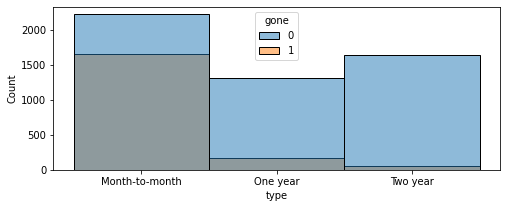

Столбец:  paperless_billing


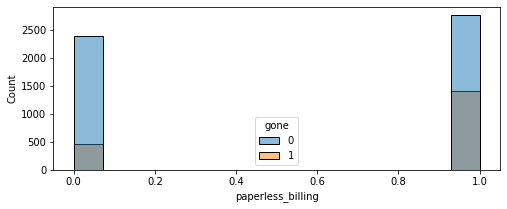

Столбец:  payment_method


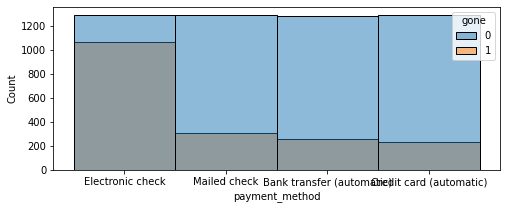

Столбец:  monthly_charges


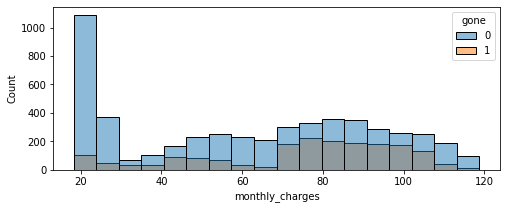

Столбец:  total_charges


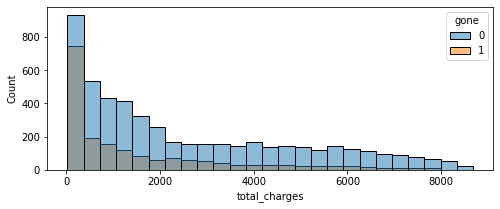

Столбец:  gone


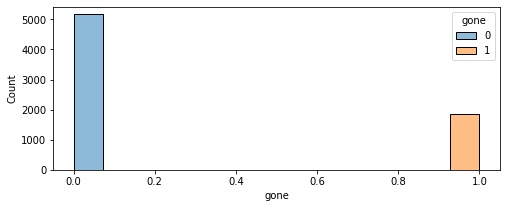

Столбец:  cooperation_time


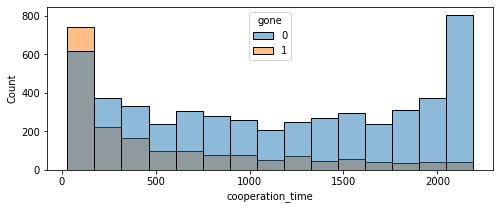

Столбец:  gender


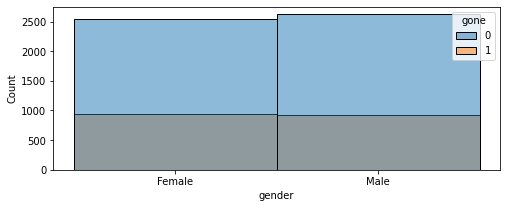

Столбец:  senior_citizen


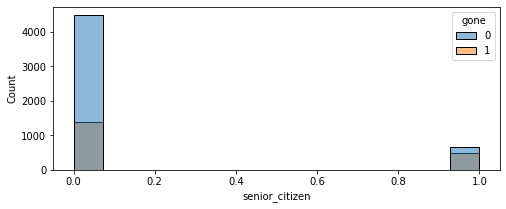

Столбец:  partner


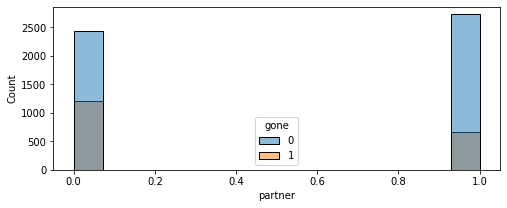

Столбец:  dependents


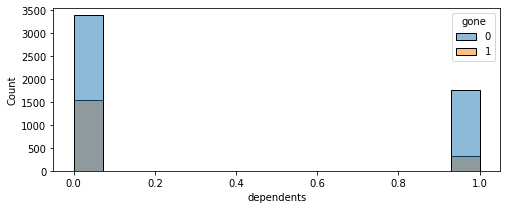

Столбец:  internet_service


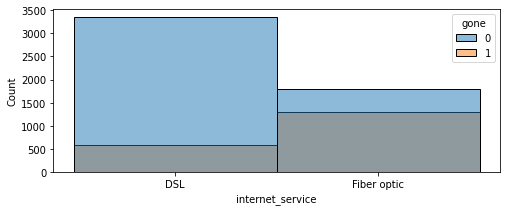

Столбец:  online_security


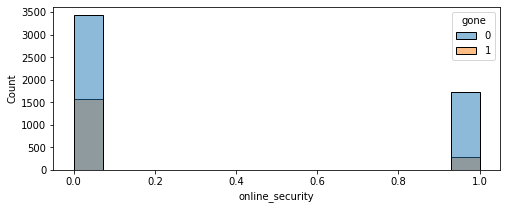

Столбец:  online_backup


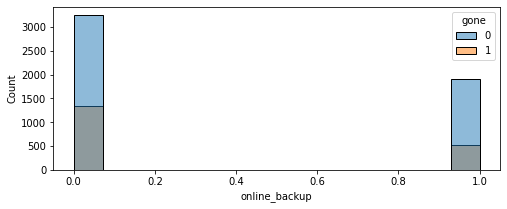

Столбец:  device_protection


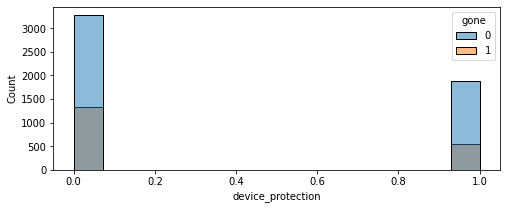

Столбец:  tech_support


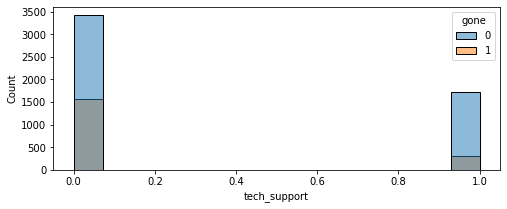

Столбец:  streaming_t_v


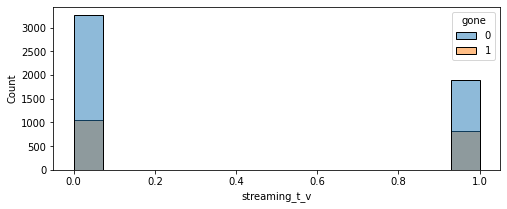

Столбец:  streaming_movies


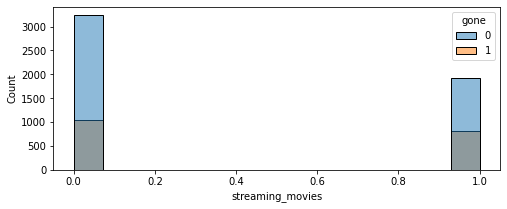

Столбец:  multiple_lines


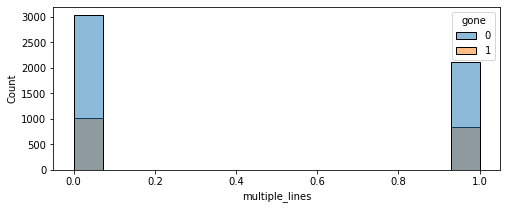

In [33]:
for col in all_data.columns:
    print('Столбец: ', col)
    plt.figure(figsize=(8, 3))
    sns.histplot(data=all_data, x=col, hue="gone")
    plt.show()

**Выводы:**
- явная зависимость оттока клиентов в первые месяцы обслуживания. 

Чаще уходят, те кто:
- платят значительную ежемесячную сумму
- платят ежемесячно 
- не используют пакеты доп. услуг
- пенсионеры, почти половина пенсионеров ушли 
- холостые, ушедших нехолостых примерно на треть меньше
- не имеющие иждевенцев, как ни странно.

В представленных данных мужчины и женщины находятся в сбалансированном соотношении как в целом, так и ушедшие/оставшиеся (видно на графике для столбца gender).






- существенного значения признак multiple_lines не оказывает.

Воспользуемся критерием корреляции phik (https://phik.readthedocs.io/en/latest/)

interval columns not set, guessing: ['paperless_billing', 'monthly_charges', 'total_charges', 'gone', 'cooperation_time', 'senior_citizen', 'partner', 'dependents', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies', 'multiple_lines']


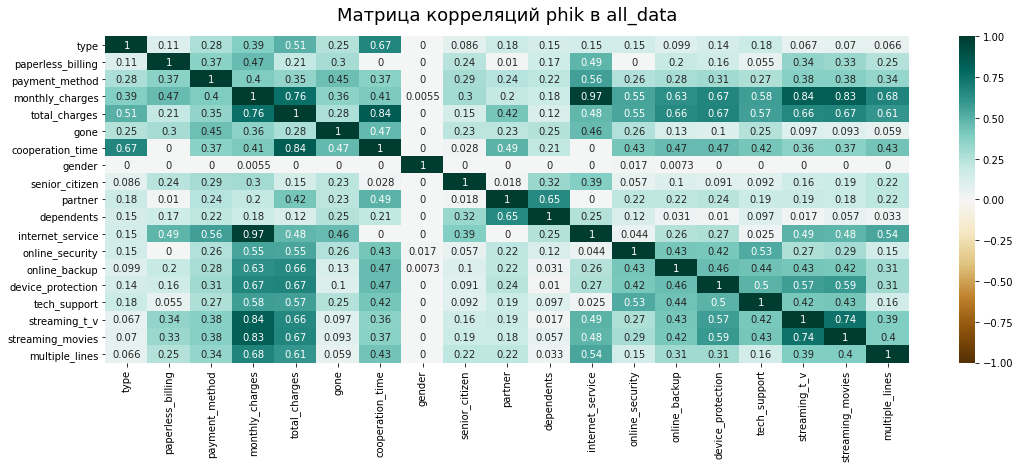

In [34]:
def do_corr_heatmap_phik(df):
    plt.figure(figsize=(18, 6))
    heatmap = sns.heatmap(all_data.phik_matrix(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
    title = "Матрица корреляций phik в " + get_df_name(df)
    heatmap.set_title(title, fontdict={'fontsize':18}, pad=16);

do_corr_heatmap_phik(all_data)

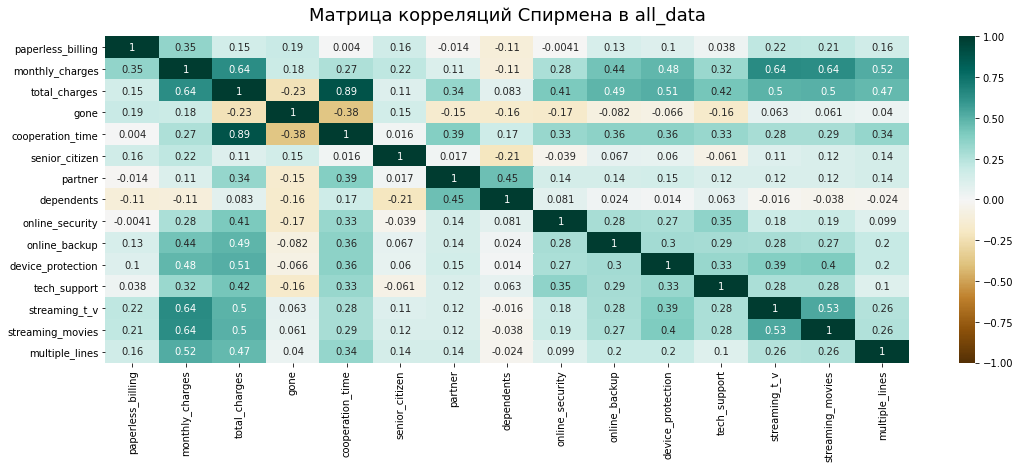

In [35]:
def do_corr_heatmap_spearmen(df):
    plt.figure(figsize=(18, 6))
    heatmap = sns.heatmap(all_data.corr(method='spearman'), vmin=-1, vmax=1, annot=True, cmap='BrBG')
    title = "Матрица корреляций Спирмена в " + get_df_name(df)
    heatmap.set_title(title, fontdict={'fontsize':18}, pad=16);

do_corr_heatmap_spearmen(all_data)

Исключим признак gender - этот признак имеет крайне малое влияние (это видно на матрицах корреляций) на целевую переменную и на остальные признаки также.

In [37]:
all_data.drop(columns=['gender'], inplace=True)

---


### Разбивка данных, OHE, upsampling

In [39]:
X = all_data.drop(columns=['gone'])
y = all_data['gone'] 

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RS)

In [41]:
X_test.head(1)

,type,paperless_billing,payment_method,monthly_charges,total_charges,cooperation_time,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines
2416,Month-to-month,1,Bank transfer (automatic),39.9,2796.35,2071,0,0,0,DSL,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [42]:
X_train.columns

Index(['type', 'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'cooperation_time', 'senior_citizen', 'partner',
       'dependents', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_t_v',
       'streaming_movies', 'multiple_lines'],
      dtype='object')

In [43]:
to_ohe_col = ['type', 'payment_method', 'internet_service']

Кодируем признаки после разбиения на выборки, чтобы избежать возможные утечки.

In [44]:
X_train = pd.get_dummies(X_train, columns = to_ohe_col, drop_first = True)
X_test = pd.get_dummies(X_test, columns = to_ohe_col, drop_first = True)

Проверим, что все прошло успешно и данные представлены в нужном нам виде.

In [45]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5274 entries, 5386 to 6040
Data columns (total 20 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   paperless_billing                       5274 non-null   int64  
 1   monthly_charges                         5274 non-null   float64
 2   total_charges                           5274 non-null   float64
 3   cooperation_time                        5274 non-null   int64  
 4   senior_citizen                          5274 non-null   int64  
 5   partner                                 5274 non-null   int64  
 6   dependents                              5274 non-null   int64  
 7   online_security                         5274 non-null   float64
 8   online_backup                           5274 non-null   float64
 9   device_protection                       5274 non-null   float64
 10  tech_support                            5274 non-null   f

In [46]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1758 entries, 2416 to 4230
Data columns (total 20 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   paperless_billing                       1758 non-null   int64  
 1   monthly_charges                         1758 non-null   float64
 2   total_charges                           1758 non-null   float64
 3   cooperation_time                        1758 non-null   int64  
 4   senior_citizen                          1758 non-null   int64  
 5   partner                                 1758 non-null   int64  
 6   dependents                              1758 non-null   int64  
 7   online_security                         1758 non-null   float64
 8   online_backup                           1758 non-null   float64
 9   device_protection                       1758 non-null   float64
 10  tech_support                            1758 non-null   f

In [47]:
X_train.head()

,paperless_billing,monthly_charges,total_charges,cooperation_time,senior_citizen,partner,dependents,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,type_One year,type_Two year,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,internet_service_Fiber optic
5386,1,81.00,389.60,153,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,1,0,0,1
5622,0,25.00,78.25,92,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0
2970,0,60.65,196.90,92,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,0,0,0,1,0
4069,1,99.35,6944.50,2132,0,1,0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0,1,1,0,0,1
6833,0,89.65,2623.65,883,0,0,0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0,0,0,0,1,1


Отказываемся от upsampling #.

In [48]:
# def upsample(features, target, repeat):
#     features_zeros = features[target == 0]
#     features_ones = features[target == 1]
#     target_zeros = target[target == 0]
#     target_ones = target[target == 1]
#     features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
#     target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
#     features_upsampled, target_upsampled = shuffle(
#     features_upsampled, target_upsampled, random_state=12345)
#     return features_upsampled, target_upsampled

In [49]:
# X_train, y_train = upsample(X_train, y_train, 2) 

### Работа с моделями

---
**Модель CatBoost**

In [50]:
%%time

param_grid = {
    'learning_rate': [0.01, 0.04, 0.1],
    'iterations': [1000],
    'l2_leaf_reg': [2, 3, 5, 10],
    #'n_estimators': [10, 20, 40, 70],
    #'max_depth': range (5, 20 ,5),
    #'min_samples_leaf': range (1,5)
    #'max_depth': []
    }

model = CatBoostClassifier(random_state=RS, verbose=0)

catboost = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
catboost.fit(X_train, y_train)

print('Наилучшие параметры модели: ', catboost.best_params_)
print('Наилучшая метрика точности модели: ', catboost.best_score_)

Наилучшие параметры модели:  {'iterations': 1000, 'l2_leaf_reg': 2, 'learning_rate': 0.1}
Наилучшая метрика точности модели:  0.907199964304328
CPU times: user 2min 12s, sys: 6.2 s, total: 2min 18s
Wall time: 3min 3s


---
**Модель RandomForest**

In [51]:
%%time
param_grid = {
    'max_depth': [30],
    'min_samples_split': [10, 15],
    'min_samples_leaf': [2, 5],
    'n_estimators': [100, 200, 300], 
}

model = RandomForestClassifier(random_state=RS)

random_forest = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
random_forest.fit(X_train, y_train)

print(random_forest.best_params_)
print(random_forest.best_score_)

{'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 300}
0.859194728371976
CPU times: user 41 s, sys: 168 ms, total: 41.1 s
Wall time: 41.1 s


---
**Модель LGBMClassifier**

In [53]:
%%time

params = [{'learning_rate': [0.05, 0.1],
                       'n_estimators': [300, 500],
                       'num_leaves': [40, 70],
                     'class_weight': ['balanced']}]

model = LGBMClassifier(objective='binary', metric='auc', random_state=RS)

lgbm = GridSearchCV(model, params, cv = 5, verbose = 0, 
                      n_jobs=1,scoring={'AUC':'roc_auc'}, refit='AUC')

lgbm.fit(X_train, y_train)
print(lgbm.best_params_)
print(lgbm.best_score_)

{'class_weight': 'balanced', 'learning_rate': 0.05, 'n_estimators': 300, 'num_leaves': 40}
0.8883716854671219
CPU times: user 24min 12s, sys: 13.8 s, total: 24min 26s
Wall time: 24min 35s


По результат проверки, наилучшие показатели удалось получить на модели CatBoost. Произведем окончательную проверку и получим итоговые метрики точности.

---

In [54]:
# Отображаем итоговую информацию о модели.
def get_resume(model_, X_test, y_test, title):
    
    print(title)
    print('==='*10)

    print('График ROC-AUC')
    pred = model_.best_estimator_.predict_proba(X_test)[:, 1]
    roc_auc = metrics.plot_roc_curve(model_, X_test, y_test) 
    plt.show()
    
    print('ROC-AUC: ', roc_auc_score(y_test, pred))
    print('Accuracy модели: ', accuracy_score(y_test, model_.best_estimator_.predict(X_test)))
    
  
    
    print('Матрица истинности')
    conf_matrix = sns.heatmap(confusion_matrix(y_test, model_.best_estimator_.predict(X_test)),
                annot=True)
    plt.show()
    
   
    print('\nВажность признаков:')
    feat_imp = pd.DataFrame(model_.best_estimator_.feature_importances_, 
                           index = X_test.columns, columns=['importances'])
    feat_imp = feat_imp.sort_values(by='importances', ascending=False)
    print(feat_imp.head(7))

Результаты модели CatBoost
График ROC-AUC


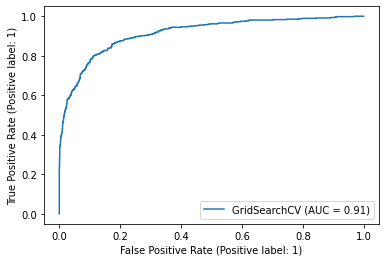

ROC-AUC:  0.9143054727357053
Accuracy модели:  0.8663253697383391
Матрица истинности


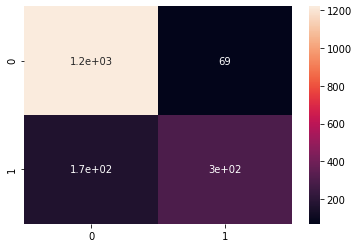


Важность признаков:
                                 importances
cooperation_time                   39.877504
monthly_charges                    13.811619
total_charges                      12.147460
type_Two year                       3.726750
internet_service_Fiber optic        3.446931
payment_method_Electronic check     2.651333
paperless_billing                   2.601473


In [55]:
get_resume(catboost, X_test, y_test, 'Результаты модели CatBoost')

### Общие выводы:
- В работе произведен анализ и построены модели для предсказания откажется ли клиент от услуг оператора сотовой связи или нет
- Данные были получены из 4-x файлов, в дальнейшем данные объеденены и произведена обработка данных
- Произведен EDA, были сделаны краткие выводы о важности признаков. Основной вывод: отказыаваются от услуг в основном новые клиенты и клиенты с высокой стоимостью пакета
- Прозведена обработка данных для подачи их в модели обучения: добавлен новый признак, удален несущественный признак, выделена целевая переменная, произведен разбивка данных на выборки, кодирование данных
- Обучены три модели CatBoost, RandomForestClassifier и LGBMClassifier

Лучший результат показала модель CatBoost со значением метрики ROC-AUC=0.914 и accuracy_score=0.876, время обучения - 2min 51s.
Самые важные факторы - как долго клиент пользуется услугами и сколько он платит в месяц, общая оплата, далее признаки уже не оказывают такого сильного влияния: тип подключения,  наличие супруга(и), способы оплаты, и т.д.